In [228]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [229]:
def setup_logging(fits_file, initial_message=None):
    # Extract the directory and base name from the FITS file path
    original_dir = os.path.dirname(os.path.dirname(os.path.dirname(fits_file)))  # Get the ObsID folder
    base_name = os.path.basename(fits_file).replace('.evt', '')  # Remove the .evt extension
    
    # Define the log file path in the ObsID folder
    log_file_path = os.path.join(original_dir, f"{base_name}.log")
    
    # Overwrite log file each time and write the initial message if provided
    with open(log_file_path, 'w') as log_file:
        if initial_message:
            log_file.write(f"{initial_message}\n")
    
    return log_file_path

def write_log_message(log_file_path, message):
    with open(log_file_path, 'a') as log_file:  # Open in append mode
        log_file.write(f"{message}\n")

In [230]:
def find_event_files(base_directory):
    event_files = []
    
    # Regular expression to match the pattern ObsID/xti/event_cl/
    obsid_pattern = re.compile(r'^\d{10}/xti/event_cl/$')
    
    # Regular expressions to match the specific filename patterns
    file_pattern = re.compile(r'^ni\d{10}_0mpu7_cl_(night|day)_barycorr\.evt$')
    
    # Walk through the directory tree
    for root, dirs, files in os.walk(base_directory):
        # Extract relative path from the base directory
        rel_path = os.path.relpath(root, base_directory)
        
        # Check if the relative path matches the pattern
        if obsid_pattern.match(rel_path + '/'):
            # Collect all files in this directory
            for file in files:
                # Check if the file matches the required patterns
                if file_pattern.match(file):
                    full_path = os.path.join(root, file)
                    event_files.append(full_path)
                # else:
                #     print(f"Ignored file: {file} in directory: {rel_path}")
    
    return event_files

In [231]:
# Orbital parameters provided
a_sin_i = 115.531  # Semi-major axis in light-seconds
P_orb = 27.6943 * 86400  # Orbital period in seconds
e = 0.1029  # Eccentricity
omega = np.deg2rad(-74.05)  # Longitude of periastron in radians
T_pi2 = 58116.097  # T_pi/2 in seconds 

In [232]:
def extract_fits_info(fits_file, log_file_path):
    with fits.open(fits_file) as hdul:
        header = hdul[1].header
        mjdrefi = header['MJDREFI']
        mjdreff = header['MJDREFF']
        leap_seconds = header.get('LEAPINIT', 0)  # Default to 0 if LEAPINIT not present
        met = hdul[1].data['BARYTIME']  # Assuming MET is stored in the 'TIME' column
    write_log_message(log_file_path, f"Extracted MET and header info from {fits_file}")
    return met, mjdrefi, mjdreff, leap_seconds

# Step 2: Convert MET to Modified Julian Date (MJD)
def convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds, log_file_path):
    met_in_days = met / 86400.0
    mjd = met_in_days + mjdrefi + mjdreff + (leap_seconds / 86400.0)
    write_log_message(log_file_path, f"Converted MET to MJD: {mjd}")
    return mjd

# Step 3: Calculate Mean Anomaly M
def calculate_mean_anomaly(mjd, T_pi2, P_orb, log_file_path):
    mean_anomaly = 2 * np.pi * ((mjd - T_pi2)) / P_orb + np.pi / 2
    write_log_message(log_file_path, f"Calculated Mean Anomaly: {mean_anomaly}")
    return mean_anomaly

# Step 4: Compute Eccentric Anomaly E using Mikkola's cubic approximation variable s
def compute_eccentric_anomaly_proxy(mean_anomaly, e, log_file_path):
    alpha = (1 - e) / (4 * e + 0.5)
    beta = 0.5 * mean_anomaly / (4 * e + 0.5)
    z = np.where(
        beta >= 0,
        np.cbrt((beta + np.sqrt(beta**2 + alpha**3))),
        np.cbrt((beta - np.sqrt(beta**2 + alpha**3)))
    )
    s = z - alpha / z
    write_log_message(log_file_path, f"Computed Eccentric Anomaly Proxy: {s}")
    return s

# Step 5: Incorporate error term as done in Mikkola 1987
def correct_eccentric_anomaly(mean_anomaly, s, e, log_file_path):
    ds = (-0.078 * s**5) / (1 + e)
    s_true = s + ds
    eccentric_anomaly = mean_anomaly + e * (3 * s_true - 4 * s_true**3)
    write_log_message(log_file_path, f"Corrected Eccentric Anomaly: {eccentric_anomaly}")
    return eccentric_anomaly

# Step 6: Calculate Rømer time delay for the binary system
def calculate_romer_delay(eccentric_anomaly, e, a_sin_i, omega, log_file_path):
    sin_E = np.sin(eccentric_anomaly)
    cos_E = np.cos(eccentric_anomaly)
    romer_delay = a_sin_i * ((cos_E - e) * np.sin(omega) + np.sqrt(1 - e**2) * sin_E * np.cos(omega))
    write_log_message(log_file_path, f"Calculated Rømer Delay: {romer_delay}")
    return romer_delay

# Step 7: Correct Event Timestamp
def correct_event_timestamp(met, romer_delay, log_file_path):
    corrected_timestamp = met - romer_delay
    write_log_message(log_file_path, f"Corrected Event Timestamp: {corrected_timestamp}")
    return corrected_timestamp

In [233]:
def write_corrected_fits(original_fits, corrected_timestamps, log_file_path):
    # Extract the base name and directory from the original FITS file
    base_name = os.path.basename(original_fits)
    original_dir = os.path.dirname(original_fits)  # Get the directory of the original file
    
    # Construct the new filename for the corrected FITS file
    new_file = os.path.join(original_dir, base_name.replace('.evt', '_orbit.evt'))

    try:
        # Modify the 'TIME' column with corrected timestamps
        with fits.open(original_fits, mode='readonly') as hdul:
            # Ensure the data is mutable
            hdul[1].data['TIME'] = corrected_timestamps
            
            # Write the new FITS file in the same directory
            hdul.writeto(new_file, overwrite=True)
        
        write_log_message(log_file_path, f"Corrected FITS file saved as {new_file}")
        
    except Exception as e:
        write_log_message(log_file_path, f"Failed to write corrected FITS file {new_file}: {str(e)}")
        print(f"Error saving corrected FITS file: {str(e)}")


In [242]:
def main(base_directory, T_pi2, P_orb, e, a_sin_i, omega):
    event_files = find_event_files(base_directory)
    for fits_file in event_files:
        log_file_path = setup_logging(fits_file)  # Setup logging and get log file path
        write_log_message(log_file_path, f"Processing file: {fits_file}")

        try:
            # Step 1: Extract info from the FITS file
            met, mjdrefi, mjdreff, leap_seconds = extract_fits_info(fits_file,log_file_path)
            write_log_message(log_file_path, f"Extracted MET and header info from {fits_file}")

            # Step 2: Convert MET to MJD
            mjd = convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds,log_file_path)
            write_log_message(log_file_path, f"Converted MET to MJD for {fits_file}")

            # Step 3: Calculate Mean Anomaly
            mean_anomaly = calculate_mean_anomaly(mjd, T_pi2, P_orb,log_file_path)
            write_log_message(log_file_path, f"Calculated Mean Anomaly for {fits_file}")

            # Step 4: Compute Eccentric Anomaly
            s = compute_eccentric_anomaly_proxy(mean_anomaly, e,log_file_path)
            write_log_message(log_file_path, f"Computed Eccentric Anomaly Proxy for {fits_file}")

            # Step 5: Correct Eccentric Anomaly
            corrected_eccentric_anomaly = correct_eccentric_anomaly(mean_anomaly, s, e,log_file_path)
            write_log_message(log_file_path, f"Corrected Eccentric Anomaly for {fits_file}")

            # Step 6: Calculate Rømer delay
            romer_delay = calculate_romer_delay(corrected_eccentric_anomaly, e, a_sin_i, omega,log_file_path)
            write_log_message(log_file_path, f"Calculated Rømer delay for {fits_file}")

            # Step 7: Correct Event Timestamps
            corrected_timestamps = correct_event_timestamp(met, romer_delay,log_file_path)
            write_log_message(log_file_path, f"Corrected event timestamps for {fits_file}")

            # Write the corrected FITS file
            write_corrected_fits(fits_file, corrected_timestamps, log_file_path)  # Pass log_file_path here
            write_log_message(log_file_path, f"Successfully processed {fits_file}")

            print('successful for: ',fits_file)
            plt.plot(met,met-corrected_timestamps)
            plt.show()

        except Exception as e:
            write_log_message(log_file_path, f"Error processing {fits_file}: {str(e)}")


successful for:  ./experimenting_orbital_correction/6050390261/xti/event_cl/ni6050390261_0mpu7_cl_night_barycorr.evt


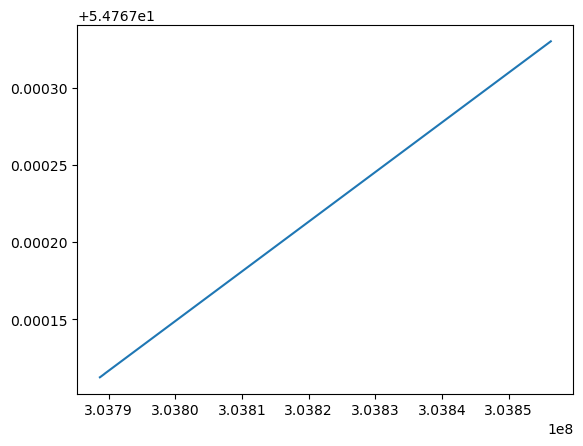

successful for:  ./experimenting_orbital_correction/6050390261/xti/event_cl/ni6050390261_0mpu7_cl_day_barycorr.evt


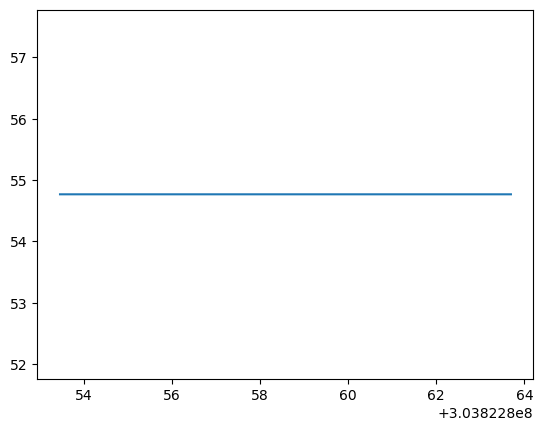

successful for:  ./experimenting_orbital_correction/6050390204/xti/event_cl/ni6050390204_0mpu7_cl_night_barycorr.evt


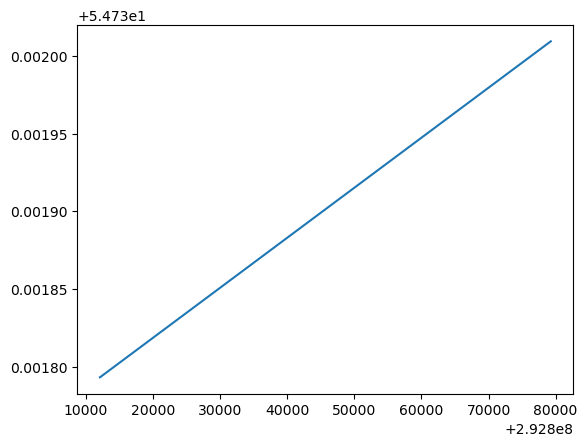

successful for:  ./experimenting_orbital_correction/6050390227/xti/event_cl/ni6050390227_0mpu7_cl_night_barycorr.evt


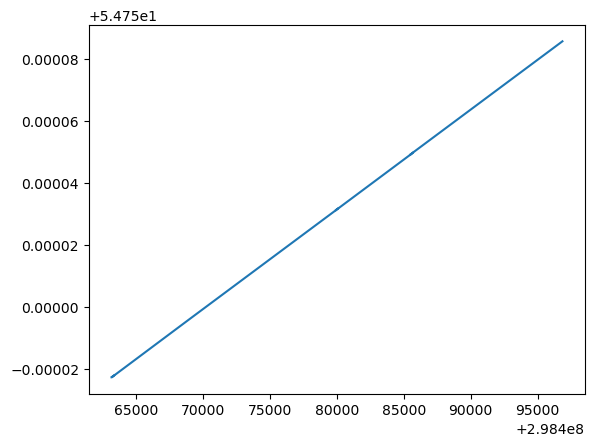

successful for:  ./experimenting_orbital_correction/6050390244/xti/event_cl/ni6050390244_0mpu7_cl_night_barycorr.evt


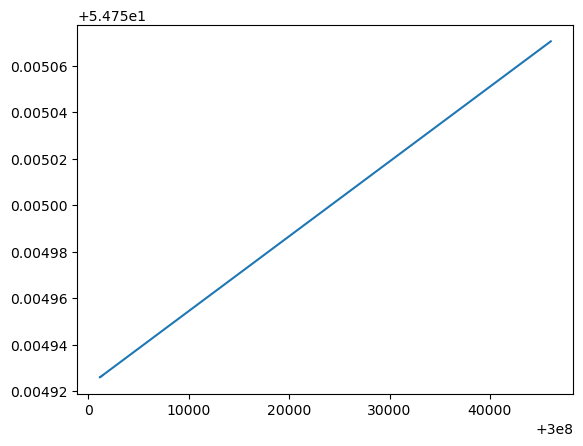

successful for:  ./experimenting_orbital_correction/6050390284/xti/event_cl/ni6050390284_0mpu7_cl_night_barycorr.evt


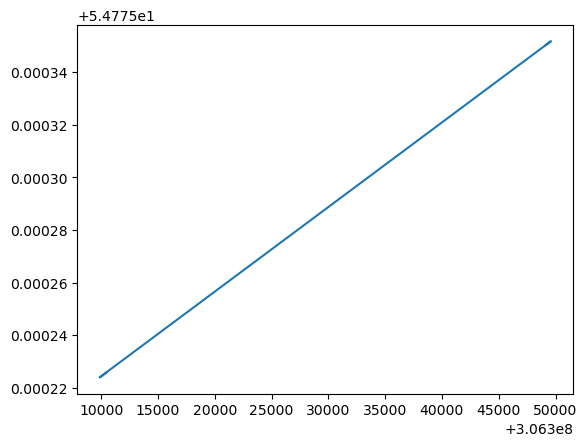

successful for:  ./experimenting_orbital_correction/6050390284/xti/event_cl/ni6050390284_0mpu7_cl_day_barycorr.evt


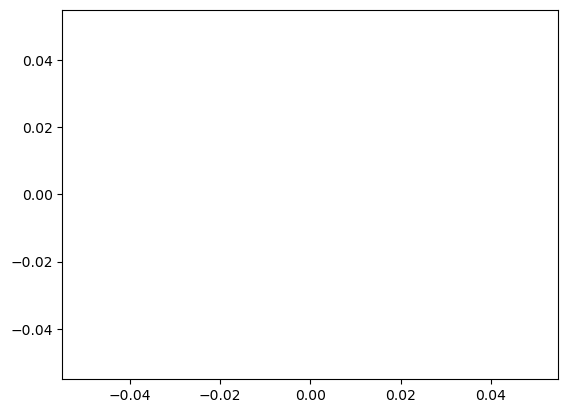

successful for:  ./experimenting_orbital_correction/6050390216/xti/event_cl/ni6050390216_0mpu7_cl_day_barycorr.evt


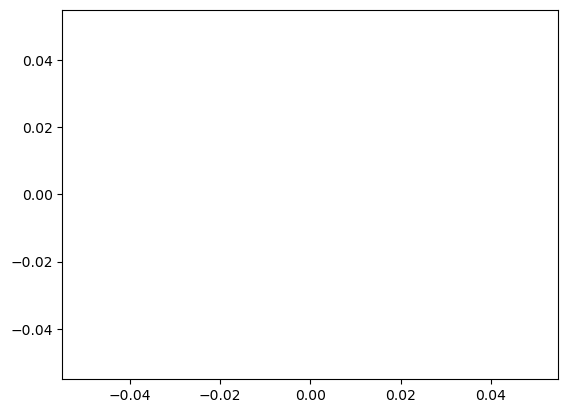

successful for:  ./experimenting_orbital_correction/6050390216/xti/event_cl/ni6050390216_0mpu7_cl_night_barycorr.evt


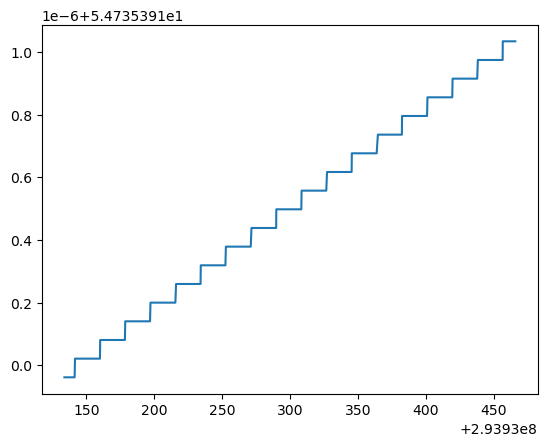

In [244]:
# Example usage
base_directory = './experimenting_orbital_correction'  # Change to your base directory
main(base_directory, T_pi2, P_orb, e, a_sin_i, omega)

In [236]:
# #***********DEBUGGING READING FILES************#
# base_directory = './'
# event_files = find_event_files(base_directory)
# print("Found event files:")
# for ef in event_files:
#     print(ef)


In [ ]:
# #********DEBUGGING MJD TIME **********##
# hdu=fits.open(fits_file)
# hdu[1].data['TIME']+hdu[1].header['MJDREFI']+hdu[1].header['MJDREFF']+hdu[1].header['LEAPINIT']